In [1]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# Batched DBSCAN with top $p_T$ tracks analysis

Initially we saw extremely positive results when we only kept the top 10 (or N) tracks in each batch. So lets see if there's any more information we can look at because this could be a promising avenue.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [3]:
import mplhep as hep

In [4]:
hep.style.use("CMS")

In [5]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.precision", 2)

In [6]:
mc_df = pd.read_pickle("/home/raichu/data/mc_25k.pkl")
trk_df = pd.read_pickle("/home/raichu/data/trk_processed_25k.pkl")

In [7]:
trk_df = trk_df.reset_index()

In [8]:
mc_df = mc_df.reset_index()

In [11]:
trk_df = trk_df.rename(columns={"entry": "event_number", "subentry": "track_number"})

In [13]:
mc_df = mc_df.rename(columns={"entry": "event_number", "subentry": "track_number"})

In [14]:
trk_df.head()

,event_number,track_number,trk_pt,trk_eta,trk_phi,trk_d0,trk_z0,trk_fake,is_pv
0,0,0,2.62,1.30,-0.29,999.0,-0.88,2,0
1,0,1,3.44,0.57,-0.16,999.0,3.34,2,0
2,0,2,3.77,1.82,-0.24,999.0,4.92,1,1
3,0,3,2.64,-1.44,-0.13,999.0,-0.47,2,0
4,0,4,2.32,1.84,0.03,999.0,4.98,1,1


## Running the script

In [16]:
import sys

sys.path.append("..")

In [17]:
from notebooks.primaryvertexingtools import PrimaryVertexing, PerformanceMetrics

In [18]:
fh_bins = np.linspace(-15, 15, 256)

In [19]:
from run_dbscan import run_normal_dbscan

In [20]:
max_number_of_tracks = 232
max_number_of_tracks_power_2 = 256
max_number_of_tracks_log_2 = 8
batch_size = 50

eps = 0.15
verbose = False
save_intermediate = False

In [21]:
from batched_dbscan import BatchedDBSCAN

In [27]:
def run_efficiency(
    mc: pd.DataFrame, trk: pd.DataFrame, nevents: int = 2000, top_pt_n: int = 10
) -> float:

    z0_mc = []
    z0_pvs = []
    z0_dbs = []
    z0_dbs_wm = []

    for i in tqdm(range(nevents)):
        mask_trk = trk_df["event_number"] == i
        mask_mc = mc_df["event_number"] == i
        mc = mc_df.loc[mask_mc, "pv_MC"].values

        e = trk_df.loc[mask_trk, ["trk_z0", "trk_pt"]].values
        z0 = e[:, 0]
        pt = e[:, 1]

        if z0.shape[0] >= 232:
            # print("continued")
            continue

        z0_mc.append(mc)
        z0_pv, _ = run_normal_dbscan(z0, pt, eps)
        z0_pvs.append(z0_pv)

        db = BatchedDBSCAN(
            z0,
            pt,
            0.15,
            50,
            232,
            False,
            False,
            fh_metric=False,
            at_end=False,
            rank_by_pt=True,
            top_pt_n=top_pt_n,
        )
        db.fit()
        z0_dbs.append(db.z0_pv)

        db_wm = BatchedDBSCAN(
            z0,
            pt,
            0.15,
            50,
            232,
            False,
            False,
            fh_metric=True,
            at_end=False,
            fh_nbins=5,
            rank_by_pt=True,
            top_pt_n=top_pt_n,
        )
        db_wm.fit()

        z0_dbs_wm.append(db_wm.z0_pv_wm)

    r = pd.DataFrame(
        {
            "z0_mc": z0_mc,
            "z0_normal": z0_pvs,
            "z0_pt_median": z0_dbs,
            "z0_pt_wm": z0_dbs_wm,
        }
    )
    effs = {"eff": 0, "eff_med": 0, "eff_wm": 0}
    for col, e_name in zip(
        ["z0_normal", "z0_pt_median", "z0_pt_wm"], ["eff", "eff_med", "eff_wm"]
    ):
        eff = 100 * np.sum((np.abs(r["z0_mc"] - r[col]) < 0.15)) / r.shape[0]
        effs[e_name] = eff
    return effs

In [29]:
test = run_efficiency(mc_df, trk_df, nevents=10, top_pt_n=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.82it/s]


In [30]:
test

{'eff': 77.77777777777777, 'eff_med': 100.0, 'eff_wm': 88.88888888888889}

In [22]:
z0_pvs = []
z0_batched = []
z0_batched_skl = []
z0_batched_skl_wm = []
z0_batched_acc_wm = []
z0_batched_acc_pt = []
z0_batched_acc_pt_wm = []

z0_mc = []

pt_pvs = []
pt_batched = []
pt_batched_skl = []
pt_batched_skl_wm = []
pt_batched_acc_wm = []
pt_batched_acc_pt = []
pt_batched_acc_pt_wm = []




for i in tqdm(range(1)):
    mask_trk = trk_df["event_number"] == i
    mask_mc = mc_df["event_number"] == i
    mc = mc_df.loc[mask_mc, "pv_MC"].values

    e = trk_df.loc[mask_trk, ["trk_z0", "trk_pt"]].values
    z0 = e[:, 0]
    pt = e[:, 1]

    if z0.shape[0] >= 232:
        print("continued")
        continue

    z0_mc.append(mc)

    # Running regular dbscan without any batchign (sklearn+median)
    z0_pv, pt_pv = run_normal_dbscan(z0, pt, eps)
    z0_pvs.append(z0_pv)

    # Running regular batched dbscan with median statistic
    db = BatchedDBSCAN(
        z0,
        pt,
        eps,
        batch_size,
        max_number_of_tracks,
        verbose,
        save_intermediate,
        fh_metric=False,
        at_end=False,
    )

    db.fit()
    z0_batched.append(db.z0_pv)

    # Running batched dbscan with pt ranking and cut (median metric)
    db_pt = BatchedDBSCAN(
        z0,
        pt,
        eps,
        batch_size,
        max_number_of_tracks,
        verbose,
        save_intermediate,
        fh_metric=False,
        at_end=False,
        rank_by_pt=True,
        top_pt_n=10,
        fh_nbins=3,
    )
    db_pt.fit()
    z0_batched_acc_pt.append(db_pt.z0_pv)

    # Running batched dbscan with pt ranking and cut (weighted mean metric)
    db_pt_wm = BatchedDBSCAN(
        z0,
        pt,
        eps,
        batch_size,
        max_number_of_tracks,
        verbose,
        save_intermediate,
        fh_metric=True,
        at_end=False,
        rank_by_pt=True,
        top_pt_n=10,
        fh_nbins=20,
    )
    db_pt_wm.fit()
    z0_batched_acc_pt_wm.append(db_pt_wm.z0_pv_wm)


r = pd.DataFrame(
    {
        "z0_mc": z0_mc,
        "z0_normal": z0_pvs,
        "z0_batched": z0_batched,
        "z0_batched_acc_pt": z0_batched_acc_pt,
        "z0_batched_acc_pt_wm": z0_batched_acc_pt_wm,
    }
)

d = pd.DataFrame({})
effs = {}

for col in ["z0_normal", "z0_batched", "z0_batched_acc_pt", "z0_batched_acc_pt_wm"]:

    eff = 100 * np.sum((np.abs(r["z0_mc"] - r[col]) < 0.15)) / r.shape[0]
    effs[col] = eff
    print(f"Efficiency {col}: ", eff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.38it/s]


Efficiency z0_normal:  100.0
Efficiency z0_batched:  100.0
Efficiency z0_batched_acc_pt:  100.0
Efficiency z0_batched_acc_pt_wm:  100.0


In [14]:
db_pt_wm.fxs

array([-25.97, -19.48, -20.71, -13.23,  -8.95,   9.16,  12.81,   0.  ,
         0.  ,   0.  ,   0.  , -19.48,   0.  ,   0.  ,   0.  ,   0.  ,
        19.76,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  , 168.34,   0.  ,   0.  ,   0.  ,   0.  ,
        -0.84,   5.89,   0.  , 168.34,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  , -22.98, -20.29, -13.03,  -5.37,   9.87,  10.47,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  , -21.53, -12.44,  -3.21,  -1.36,
         8.93,  11.67,  13.49,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
      

In [15]:
db_pt_wm.Ns

array([ 4.87,  3.78,  5.7 ,  4.11,  4.49,  4.22,  4.55,  0.  ,  0.  ,
        0.  ,  0.  ,  3.78,  0.  ,  0.  ,  0.  ,  0.  ,  4.01,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       33.84,  0.  ,  0.  ,  0.  ,  0.  ,  2.05,  2.45,  0.  , 33.84,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  3.3 ,  4.03,  4.36,  4.16,
        3.24,  3.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  3.31,  4.52,  3.23,  3.32,  3.47,  3.16,  3.38,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

In [16]:
db_pt_wm.Ns.shape

(250,)

In [17]:
db_pt_wm.max_pt_i

35

In [18]:
db_pt_wm.clusters.sort_values(by="pt_sum", ascending=False)

,pt_sum,z0_low,z0_high,noise
35,53.65,4.80,5.04,0.0
2,10.34,-3.63,-3.63,0.0
11,7.81,-5.16,-5.04,0.0
32,7.39,-0.41,-0.41,0.0
31,6.92,-3.05,-2.99,0.0
30,6.61,-6.56,-6.50,0.0
34,6.09,3.22,3.22,0.0
0,4.87,-5.33,-5.33,1.0
6,4.55,2.81,2.81,1.0
21,4.52,-2.75,-2.75,1.0


In [19]:
r

,z0_mc,z0_normal,z0_batched,z0_batched_acc_pt,z0_batched_acc_pt_wm
0,[5.055163],4.98,4.98,4.98,4.97


In [ ]:
df

In [26]:
db.z0_batches[0]

array([-6.15, -5.33, -5.16, -4.86, -3.63, -3.63, -3.22, -3.05, -2.99,
       -2.23, -1.99, -1.93, -1.88, -1.7 , -1.64, -1.17, -1.11, -1.11,
       -0.88, -0.88, -0.53, -0.47, -0.47, -0.41, -0.35, -0.06,  0.18,
        0.18,  0.64,  1.  ,  1.35,  2.05,  2.17,  2.34,  2.46,  2.52,
        2.58,  2.64,  2.75,  2.75,  2.81,  3.34,  4.22,  4.92,  4.98,
        5.51,  5.62,  5.86,  6.09,  7.85])

In [28]:
db.pt_batches[0]

array([3.1 , 4.87, 3.78, 1.96, 5.7 , 4.64, 4.11, 2.34, 3.1 , 2.98, 4.49,
       3.16, 3.13, 2.45, 3.2 , 3.31, 2.75, 2.36, 2.62, 2.1 , 2.08, 3.03,
       2.64, 2.74, 1.97, 2.32, 2.05, 2.26, 2.6 , 2.77, 3.75, 2.22, 4.22,
       3.32, 2.46, 3.08, 2.66, 3.46, 2.91, 3.58, 4.55, 3.44, 3.98, 3.77,
       2.32, 3.2 , 3.66, 5.55, 2.43, 2.83])

In [29]:
db_pt.z0_batches[0]

array([-5.33, -5.16, -3.63, -3.63, -3.22, -1.99,  2.17,  2.81,  4.22,
        5.86])

In [30]:
db_pt.pt_batches[0]

array([4.87, 3.78, 5.7 , 4.64, 4.11, 4.49, 4.22, 4.55, 3.98, 5.55])

In [31]:
mc

array([5.06], dtype=float32)

In [33]:
for i in range(5):
    print(db_pt.z0_batches[i])
    print(db_pt.pt_batches[i])
    print("---------------------------")

[-5.33 -5.16 -3.63 -3.63 -3.22 -1.99  2.17  2.81  4.22  5.86]
[4.87 3.78 5.7  4.64 4.11 4.49 4.22 4.55 3.98 5.55]
---------------------------
[-6.97 -5.04 -2.99 -1.29  3.05  3.22  4.92  4.92  5.1   5.16]
[3.3  4.03 4.36 4.16 3.24 3.25 4.01 3.59 3.21 3.65]
---------------------------
[-6.5  -2.75 -1.   -0.41  2.58  3.69  3.98  4.98  4.98  5.04]
[ 3.31  4.52  3.23  3.32  3.47  3.16  3.38 18.57 11.26 13.91]
---------------------------
[-6.56 -3.05 -0.41 -0.41  2.4   2.4   3.22  4.8   5.57 21.  ]
[3.3  2.56 2.05 2.03 2.45 2.01 2.84 2.3  2.22 0.  ]
---------------------------
[21. 21. 21. 21. 21. 21. 21. 21. 21. 21.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---------------------------


In [38]:
db.clusters[db.clusters.z0_low<21].sort_values(by='z0_low')

,pt_sum,z0_low,z0_high,noise
100,4.72,-7.44,-7.44,0.0
51,3.30,-6.97,-6.97,1.0
150,6.61,-6.56,-6.50,0.0
103,11.66,-6.33,-6.04,0.0
104,21.39,-5.33,-4.86,0.0
105,2.30,-4.45,-4.45,1.0
106,12.05,-4.22,-4.04,0.0
107,24.71,-3.81,-3.52,0.0
151,37.38,-3.28,-2.75,0.0
59,7.79,-2.46,-2.40,0.0


In [41]:
db_pt.clusters[db_pt.clusters.z0_low<21].sort_values(by='z0_low')

,pt_sum,z0_low,z0_high,noise
10,3.30,-6.97,-6.97,1.0
30,6.61,-6.56,-6.50,0.0
0,4.87,-5.33,-5.33,1.0
11,7.81,-5.16,-5.04,0.0
2,10.34,-3.63,-3.63,0.0
3,4.11,-3.22,-3.22,1.0
31,6.92,-3.05,-2.99,0.0
21,4.52,-2.75,-2.75,1.0
4,4.49,-1.99,-1.99,1.0
13,4.16,-1.29,-1.29,1.0


In [44]:
db_pt_wm.clusters[db_pt_wm.clusters.z0_low<21].sort_values(by='z0_low')

,pt_sum,z0_low,z0_high,noise
10,3.30,-6.97,-6.97,1.0
30,6.61,-6.56,-6.50,0.0
0,4.87,-5.33,-5.33,1.0
11,7.81,-5.16,-5.04,0.0
2,10.34,-3.63,-3.63,0.0
3,4.11,-3.22,-3.22,1.0
31,6.92,-3.05,-2.99,0.0
21,4.52,-2.75,-2.75,1.0
4,4.49,-1.99,-1.99,1.0
13,4.16,-1.29,-1.29,1.0


In [20]:
print("hi")

hi


## How many tracks should we drop?

In [37]:
limits = [5, 10, 15, 20, 30, 40]
eff_base = []
eff_med = []
eff_wm = []
for lim in limits:
    _effs = run_efficiency(mc_df, trk_df, nevents=2000, top_pt_n=lim)
    eff_base.append(_effs["eff"])
    eff_med.append(_effs["eff_med"])
    eff_wm.append(_effs["eff_wm"])

 10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                   | 201/2000 [00:09<01:41, 17.71it/s]/home/raichu/Documents/db-clustering/batched_dbscan/batched_dbscan.py:468: RuntimeWarning: invalid value encountered in double_scalars
  self.z0_pv_wm = self.fxs[max_pt_i] / self.Ns[max_pt_i]
 13%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                          | 254/2000 [00:12<01:17, 22.40it/s]/home/raichu/Documents/db-clustering/batched_dbscan/batched_dbscan.py:468: Runti

In [38]:
eff_base

[78.05393971443681,
 78.05393971443681,
 78.05393971443681,
 78.05393971443681,
 78.05393971443681,
 78.05393971443681]

In [203]:
eff_base = 6 * [78.05393971443681]

In [39]:
eff_med

[82.70756213643575,
 89.26493918561607,
 89.05341089370704,
 88.84188260179799,
 86.19777895293495,
 82.76044420941301]

In [205]:
eff_med = [
    82.70756213643575,
    89.26493918561607,
    89.05341089370704,
    88.84188260179799,
    86.19777895293495,
    82.76044420941301,
]

In [40]:
eff_wm

[79.74616604970915,
 86.72659968270756,
 78.68852459016394,
 76.25594923320995,
 70.49180327868852,
 68.16499206768906]

In [206]:
eff_wm = [
    79.74616604970915,
    86.72659968270756,
    78.68852459016394,
    76.25594923320995,
    70.49180327868852,
    68.16499206768906,
]

In [ ]:
test = run_efficiency(mc_df, trk_df, nevents=10, top_pt_n=5)

In [201]:
print("hi")

hi


In [208]:
limits = [5, 10, 15, 20, 30, 40]

In [216]:
fh_eff_base2k = 74.66

Text(0.5, 1.0, 'Performance as a function of tracks kept')

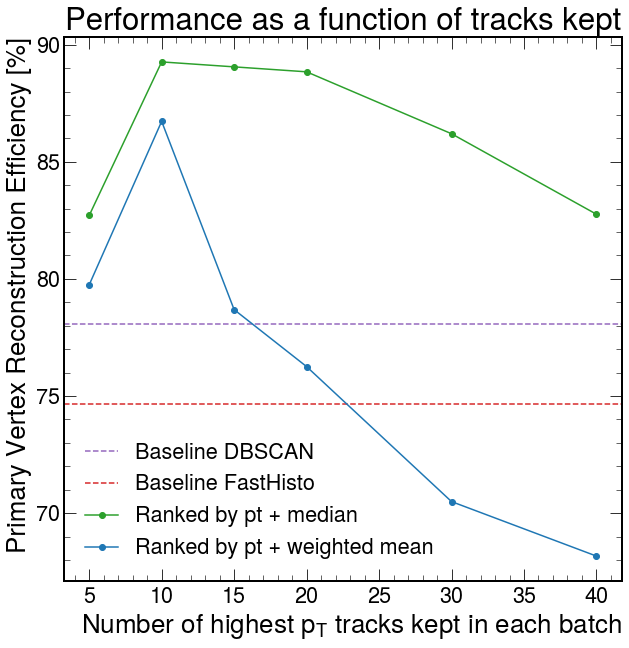

In [218]:
plt.axhline(eff_base[0], ls="--", label="Baseline DBSCAN", color="tab:purple")
plt.axhline(fh_eff_base2k, ls="--", label="Baseline FastHisto", color="tab:red")
plt.plot(limits, eff_med, marker="o", label="Ranked by pt + median", color="tab:green")
plt.plot(
    limits, eff_wm, marker="o", label="Ranked by pt + weighted mean", color="tab:blue"
)
plt.legend()
plt.xlabel("Number of highest $p_T$ tracks kept in each batch")
plt.ylabel("Primary Vertex Reconstruction Efficiency [%]")
plt.title("Performance as a function of tracks kept")

Text(0, 1, 'Primary Vertex Reconstruction Efficiency [%]')

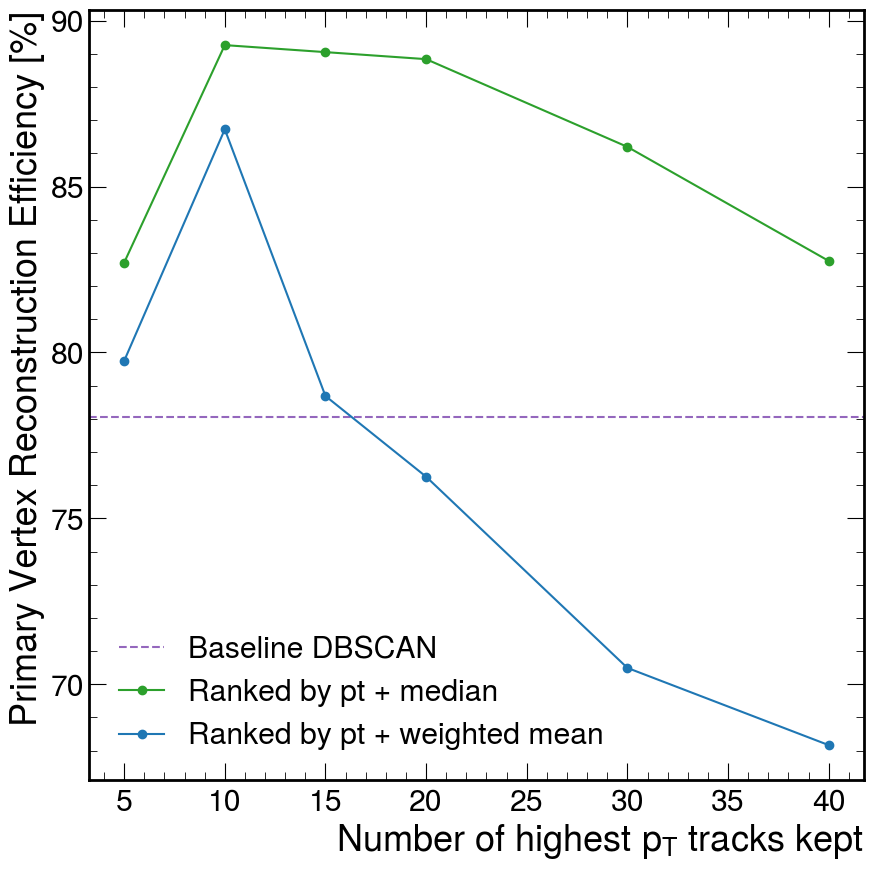

In [47]:
plt.axhline(eff_base[0], ls="--", label="Baseline DBSCAN", color="tab:purple")
plt.plot(limits, eff_med, marker="o", label="Ranked by pt + median", color="tab:green")
plt.plot(
    limits, eff_wm, marker="o", label="Ranked by pt + weighted mean", color="tab:blue"
)
plt.legend()
plt.xlabel("Number of highest $p_T$ tracks kept")
plt.ylabel("Primary Vertex Reconstruction Efficiency [%]")

As this looks really promising lets do a more detailed comparison with the fasthisto and the normal metrics.
For this we will need to incorporate the `BatchedDBSCAN` class into the `primaryvertexingtools`. Shouldn't be a problem.

# Deep analysis

In [6]:
import sys

sys.path.append("../")

In [7]:
from notebooks.primaryvertexingtools import PrimaryVertexing, PerformanceMetrics

In [8]:
fh_bins = np.linspace(-15, 15, 256)

In [13]:
!ls -lh /home/lucas/Documents/RA/raichu/data/

total 170M
drwxr-xr-x 9 lucas lucas 4.0K Jan 10 16:24 data
-rw-r--r-- 1 lucas lucas 2.2M Jan 10 16:07 mc_25k.pkl
-rw-r--r-- 1 lucas lucas 168M Jan 10 16:07 trk_processed_25k.pkl


In [14]:
mc_df2 = pd.read_pickle("/home/lucas/Documents/RA/raichu/data/mc_25k.pkl")
trk_df2 = pd.read_pickle("/home/lucas/Documents/RA/raichu/data/trk_processed_25k.pkl")

In [93]:
# trk_df2["event_number"] = trk_df2.index.get_level_values(0).values

In [94]:
# trk_count = trk_df2.groupby(["entry"])["trk_pt"].count().reset_index()

In [95]:
# mask = trk_count.trk_pt > 232

In [97]:
# trk_count.columns = ["event_number", "trk_pt"]

In [98]:
# trk_to_drop = trk_count.loc[mask, "event_number"].values

In [99]:
# trk_to_drop.shape

(1411,)

In [100]:
# trk_df2 = trk_df2.loc[~trk_df2.event_number.isin(trk_to_drop)].copy()

In [106]:
# mc_df2["event_number"] = mc_df2.index.get_level_values(0).values

In [107]:
# mc_df2 = mc_df2.loc[~mc_df2.event_number.isin(trk_to_drop)].copy()

In [224]:
config = {
    "track_data": trk_df2,
    "truth_data": mc_df2,
    "fh_bins": fh_bins,
    "test_run": True,
    "nevents_test": 15000,
    "rank_by_pt": False,
}

In [225]:
trk_df2.head()

trk_pt  trk_eta  trk_phi  trk_d0  trk_z0  trk_fake  is_pv
entry subentry                                                           
0     0           2.62     1.30    -0.29   999.0   -0.88         2      0
      1           3.44     0.57    -0.16   999.0    3.34         2      0
      2           3.77     1.82    -0.24   999.0    4.92         1      1
      3           2.64    -1.44    -0.13   999.0   -0.47         2      0
      4           2.32     1.84     0.03   999.0    4.98         1      1

In [226]:
pv = PrimaryVertexing(config)

Initialized Primary Vertexing setup


In [227]:
pv.run_fh()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15001/15001 [00:03<00:00, 4368.10it/s]


Ran Fast Histo


In [228]:
pv.run_dbscan(stat="median")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15001/15001 [00:44<00:00, 338.66it/s]

Ran DBSCAN with eps: 0.08, minPts: 2


In [229]:
pv.run_batched_dbscan(rank_by_pt=True, top_pt_n=10, max_number_of_tracks=1665)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [08:26<00:00, 29.60it/s]


Ran Batched DBSCAN


In [113]:
# pv.z0_reco_db

In [230]:
pm = PerformanceMetrics(pv)

0.11865044
positive bias 0.034155607
negative bias -0.035919785
positive bias 0.035721778869628906
negative bias -0.03221935033798218


In [247]:
pm.pv_efficiency((pm.z0_gen - pm.z0_reco_fh_cor), display=True)

74.72 %


In [248]:
pm.pv_efficiency((pm.z0_gen - pm.z0_reco_db_cor), display=True)

78.15 %


In [249]:
pm.pv_efficiency((pm.z0_gen - pm.z0_reco_bdb_cor), display=True)

82.81 %


# Physics performance metrics investigation

## Primary vertex reconstruction efficiecny

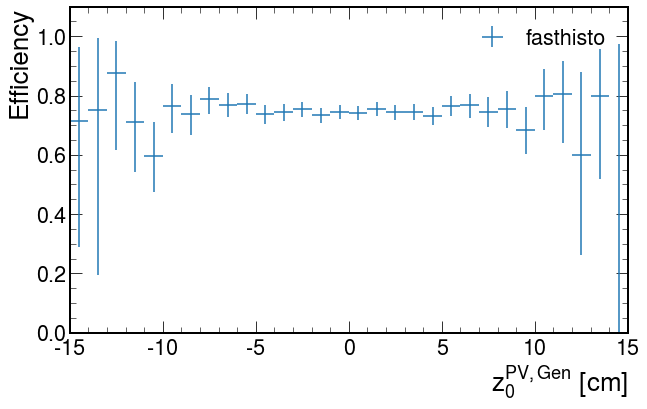

In [250]:
fh = pm.plot_pv_efficiency_z0(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_fh_cor, label="fasthisto", figsize=(10, 6)
)

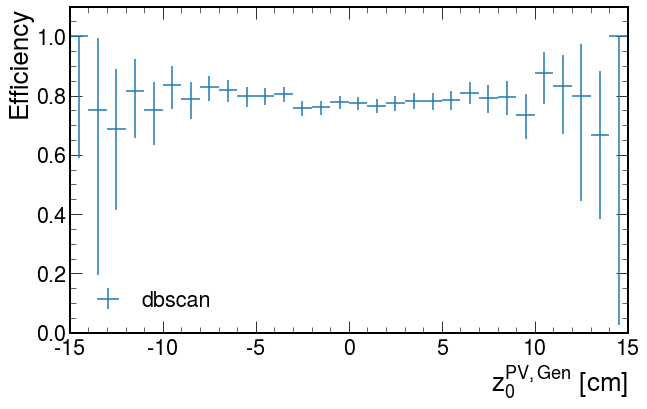

In [251]:
db = pm.plot_pv_efficiency_z0(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_db_cor, label="dbscan", figsize=(10, 6)
)

In [252]:
fh

,x,error_x,eff,ci_low,ci_upp,lower_error,upper_error
0,-14.5,0.5,0.71,0.29,0.96,0.42,0.25
1,-13.5,0.5,0.75,0.19,0.99,0.56,0.24
2,-12.5,0.5,0.88,0.62,0.98,0.26,0.11
3,-11.5,0.5,0.71,0.54,0.85,0.17,0.14
4,-10.5,0.5,0.60,0.47,0.71,0.12,0.11
5,-9.5,0.5,0.76,0.67,0.84,0.09,0.08
6,-8.5,0.5,0.74,0.67,0.80,0.07,0.06
7,-7.5,0.5,0.79,0.74,0.83,0.05,0.04
8,-6.5,0.5,0.77,0.73,0.81,0.04,0.04
9,-5.5,0.5,0.77,0.74,0.81,0.04,0.03


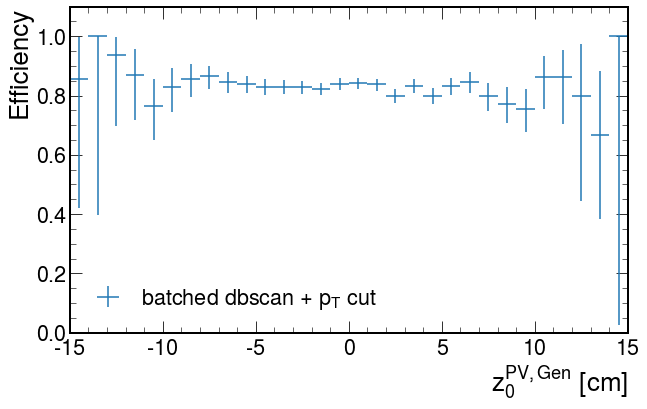

In [253]:
bdb = pm.plot_pv_efficiency_z0(
    z0_gen=pm.z0_gen,
    z0_reco=pm.z0_reco_bdb_cor,
    label="batched dbscan + $p_T$ cut",
    figsize=(10, 6),
)

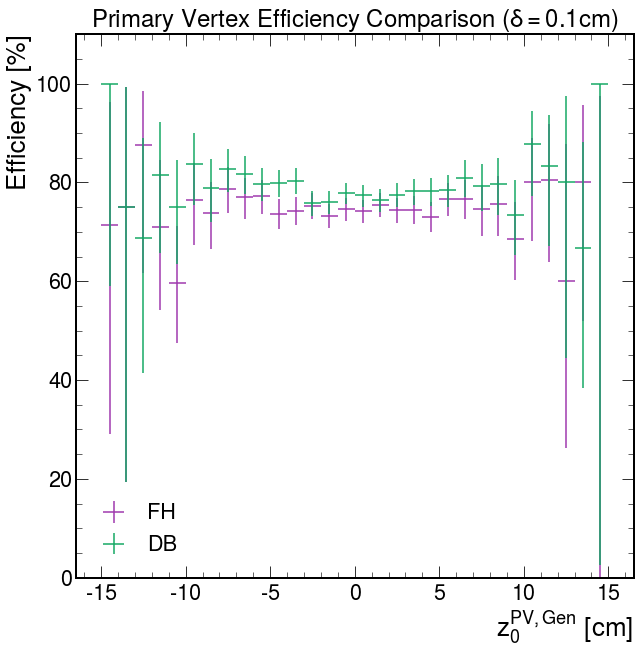

In [255]:
pm.compare_efficiency_z0(
    fh, db, labels=["FH", "DB"], filename="plots/DB_FH_pv_eff_z0.pdf"
)

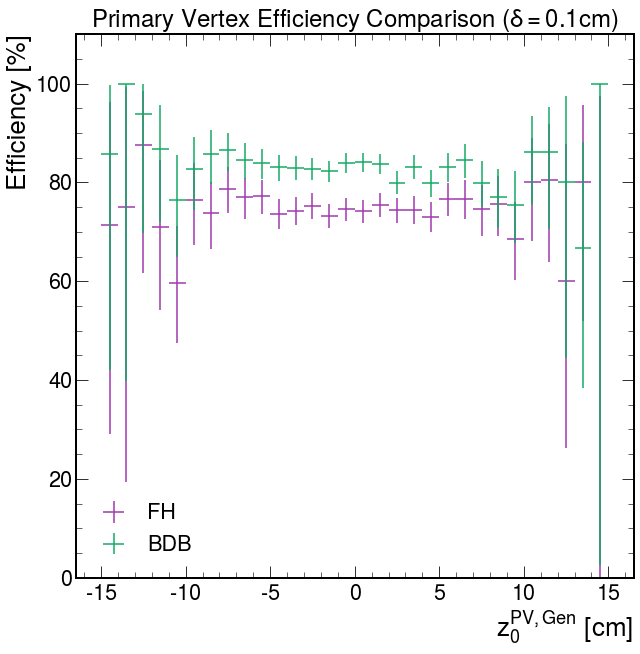

In [256]:
pm.compare_efficiency_z0(
    fh, bdb, labels=["FH", "BDB"], filename="plots/BDB_FH_pv_eff_z0.pdf"
)

In [ ]:
db

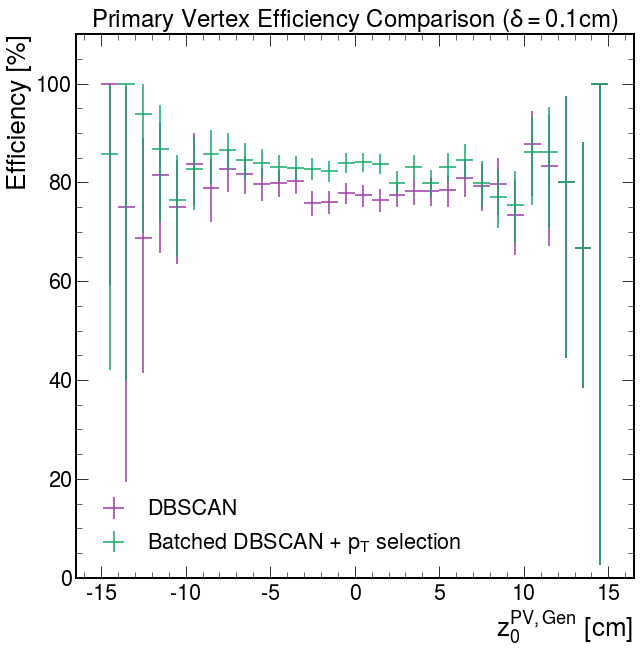

In [258]:
pm.compare_efficiency_z0(
    db,
    bdb,
    labels=["DBSCAN", "Batched DBSCAN + $p_T$ selection"],
    filename="plots/BDB_DB_pv_eff_z0.pdf",
)

## Primary vertex resolution histogram

In [259]:
res_bins = np.linspace(-5, 5, 100)

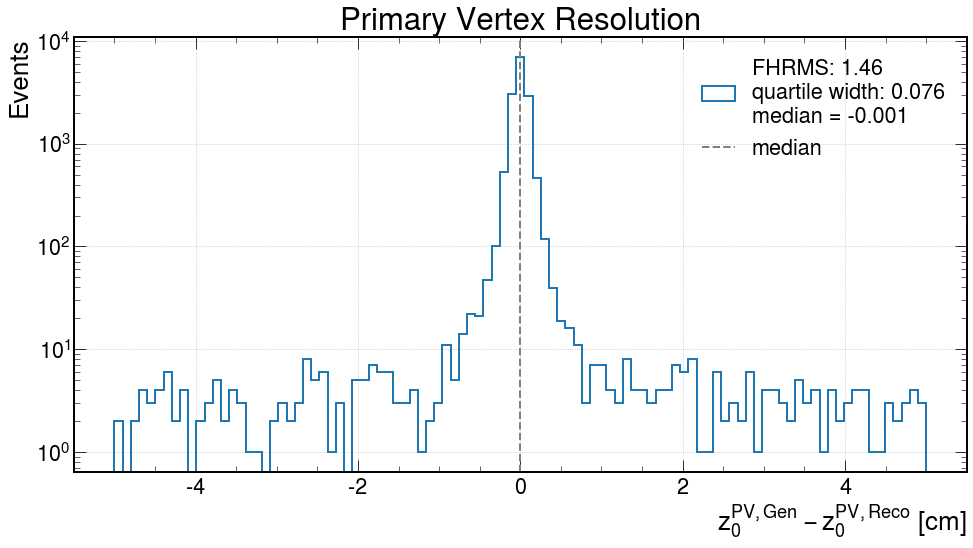

In [260]:
fh = pm.pv_resolution(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_fh_cor, bins=res_bins, label="FH"
)

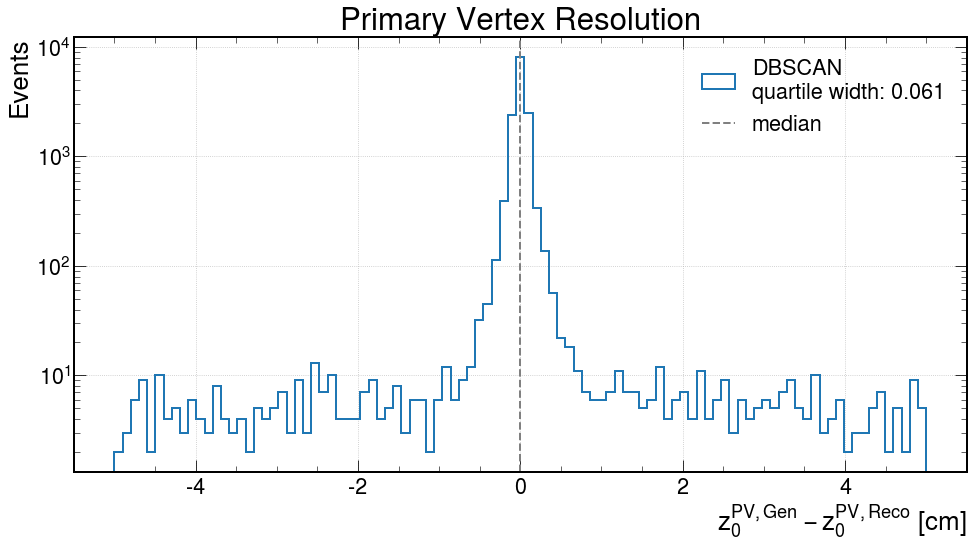

In [282]:
db = pm.pv_resolution(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_db_cor, bins=res_bins, label="DBSCAN"
)

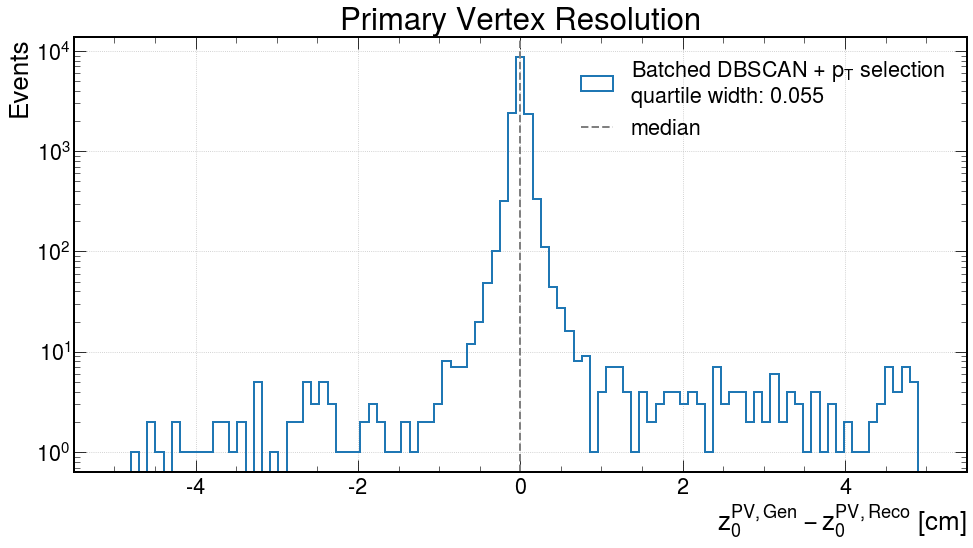

In [278]:
bdb = pm.pv_resolution(
    z0_gen=pm.z0_gen,
    z0_reco=pm.z0_reco_bdb_cor,
    bins=res_bins,
    label="Batched DBSCAN + $p_T$ selection",
)

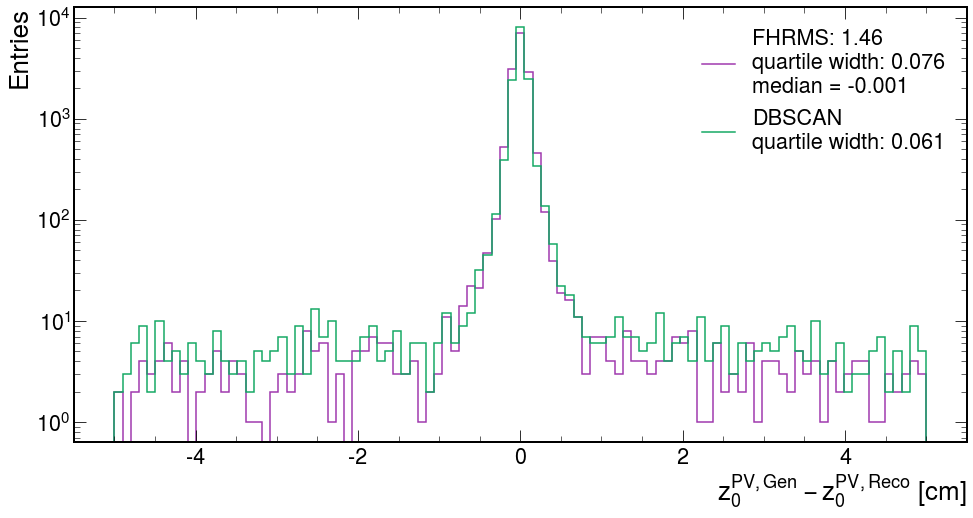

In [283]:
pm.compare_resolution_histogram(fh, db, filename="plots/DB_FH_res_histo.pdf")

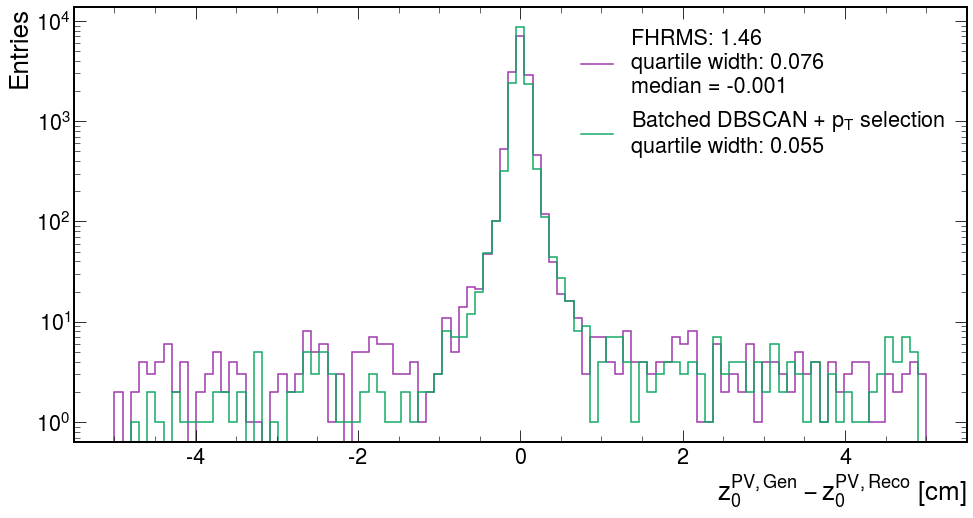

In [280]:
pm.compare_resolution_histogram(fh, bdb, filename="plots/BDB_FH_res_histo.pdf")

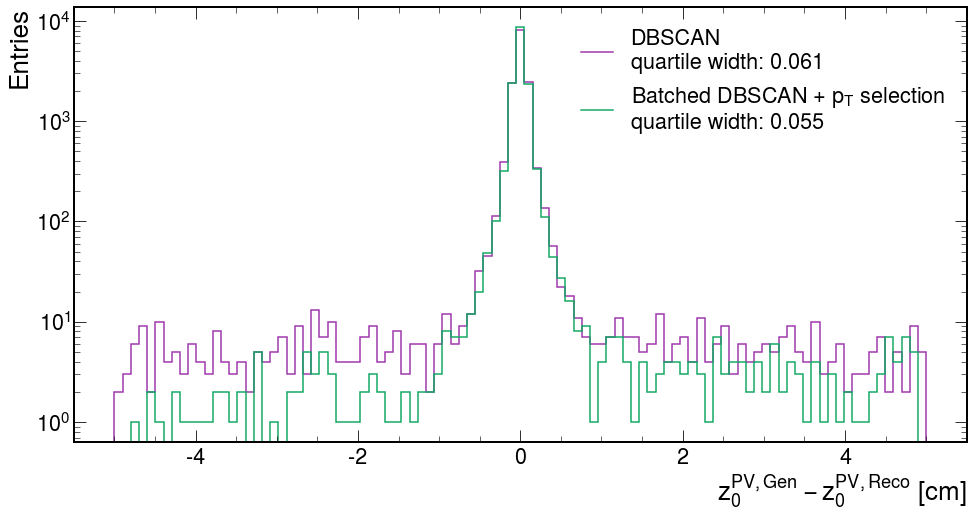

In [284]:
pm.compare_resolution_histogram(db, bdb, filename="plots/BDB_DB_res_histo.pdf")

## Primary vertex resolution vs z0

In [147]:
bins_profile = np.arange(-15, 16, 1)

/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/lucas/miniconda3/envs/db-clustering/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret /

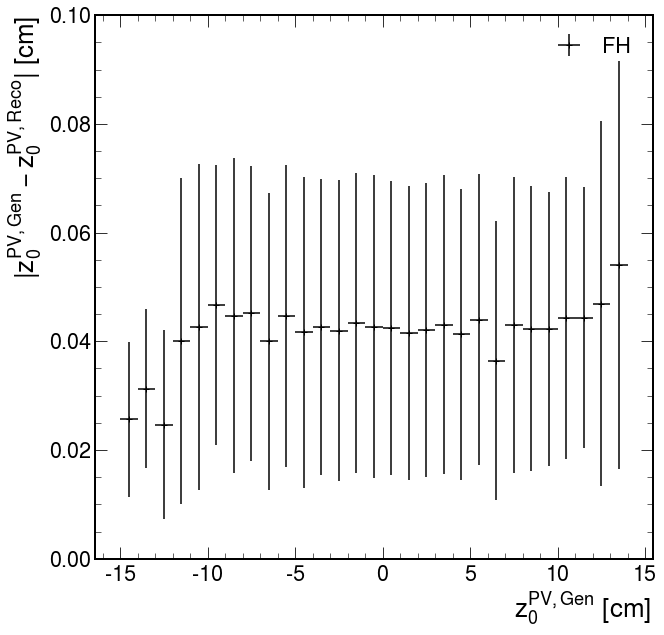

In [148]:
fh = pm.plot_pv_resolution_z0(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_fh_cor, bins=bins_profile, label="FH"
)

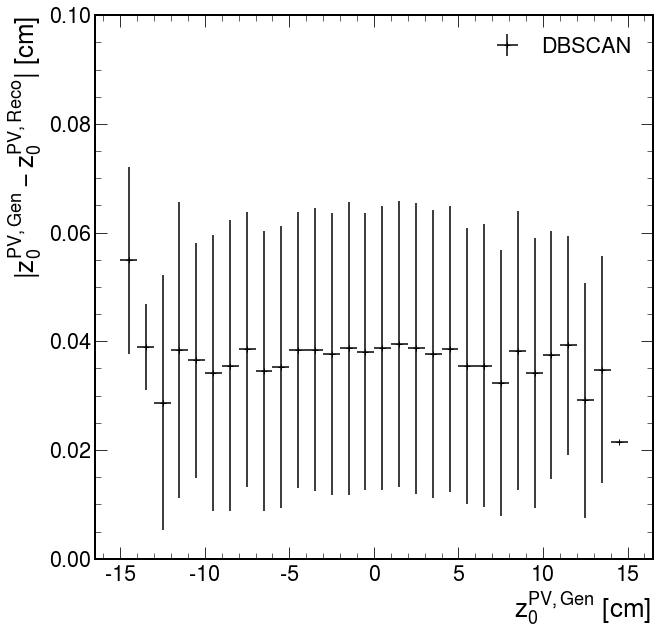

In [149]:
db = pm.plot_pv_resolution_z0(
    z0_gen=pm.z0_gen, z0_reco=pm.z0_reco_db_cor, bins=bins_profile, label="DBSCAN"
)

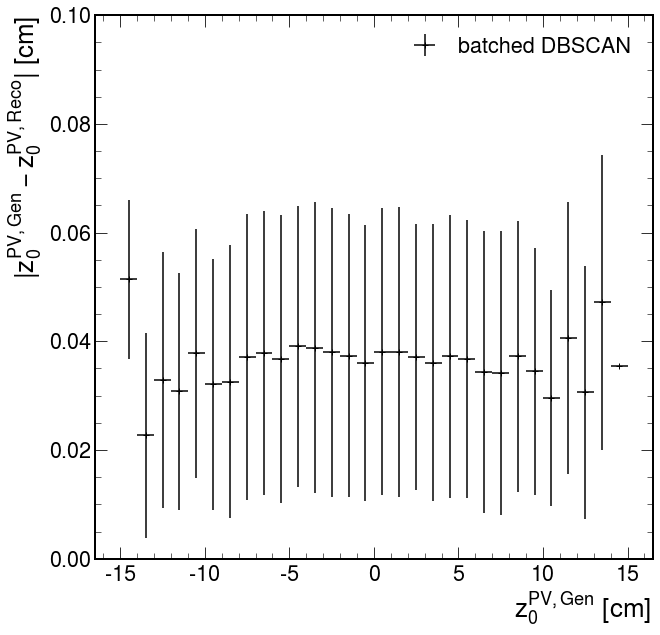

In [150]:
bdb = pm.plot_pv_resolution_z0(
    z0_gen=pm.z0_gen,
    z0_reco=pm.z0_reco_bdb_cor,
    bins=bins_profile,
    label="batched DBSCAN",
)

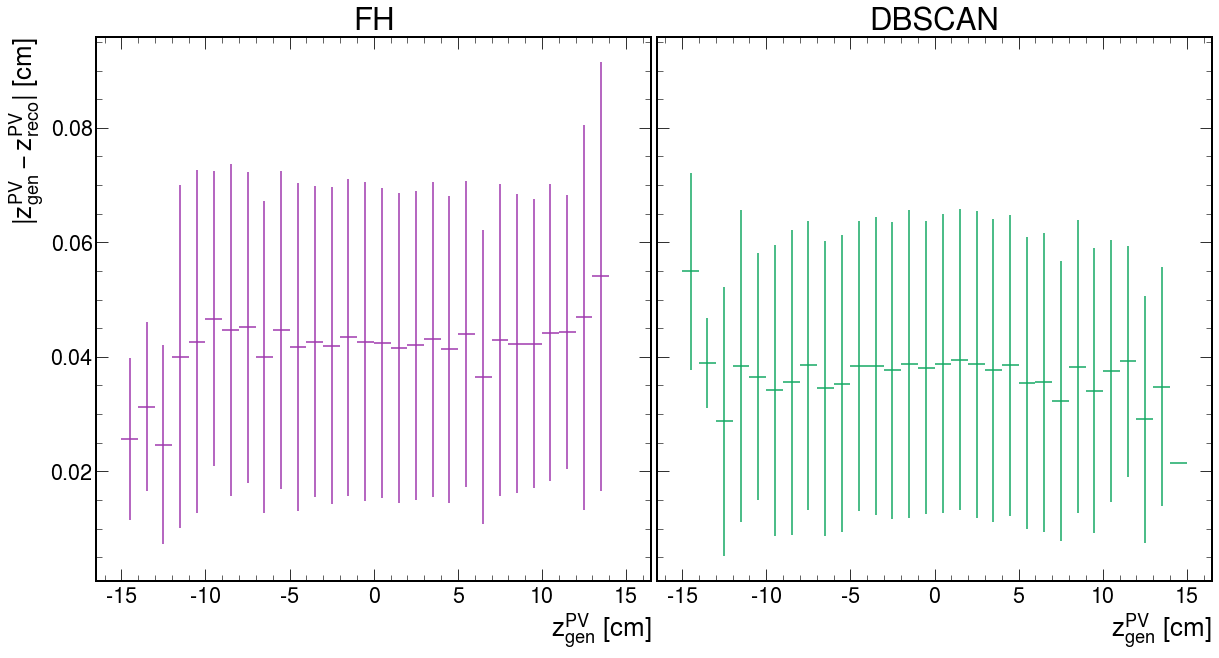

In [154]:
pm.compare_resolution_z0(fh, db)

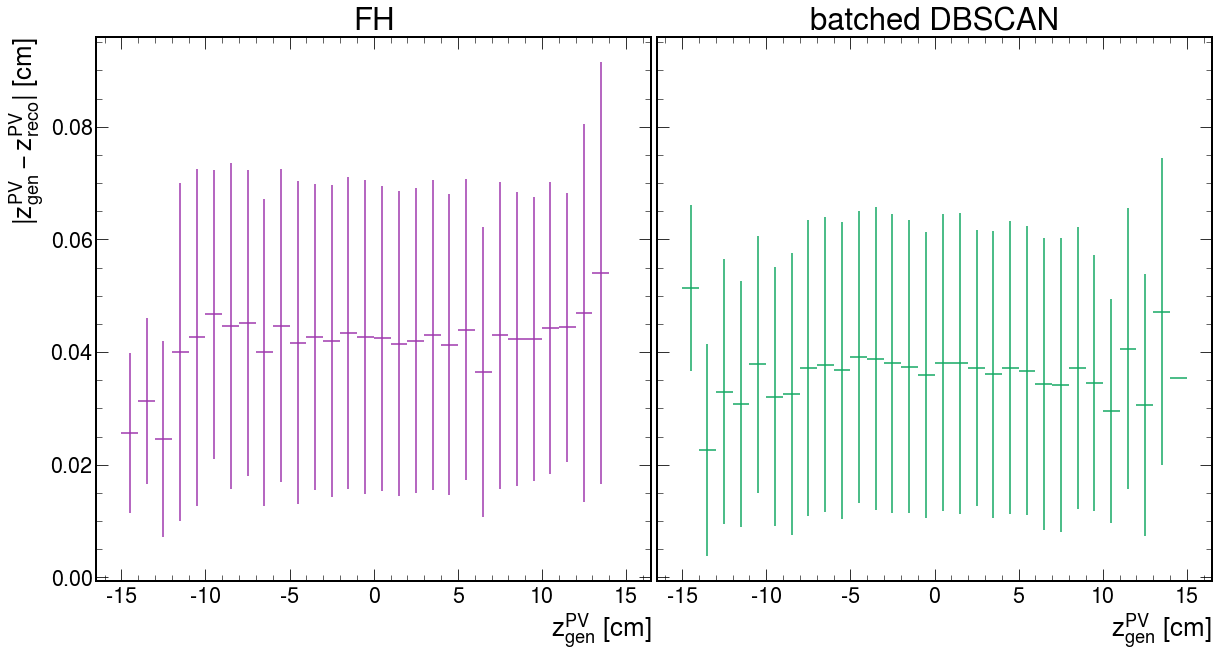

In [155]:
pm.compare_resolution_z0(fh, bdb)

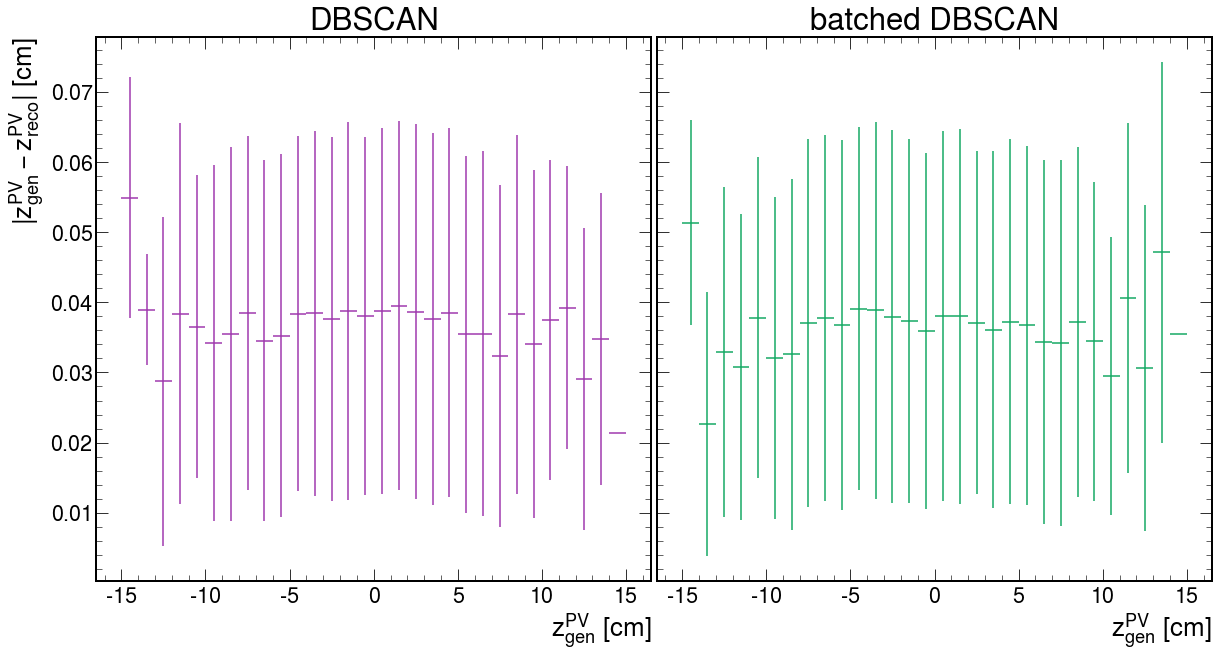

In [156]:
pm.compare_resolution_z0(db, bdb)

## Classification metrics

In [299]:
fh_metrics = pm.trk_vertex_association(
    pm.trk.is_pv.values, pm.trk.trk_pv_assoc_fh_cor.values
)
print(fh_metrics)

{'tn': 1991341, 'fp': 331042, 'fn': 30686, 'tp': 385533, 'TPR': 0.9262743892037605, 'FPR': 0.14254410232937462, 'AUC': 0.891865143437193}


In [300]:
db_metrics = pm.trk_vertex_association(
    pm.trk.is_pv.values, pm.trk.trk_pv_assoc_db_cor.values
)
print(db_metrics)

{'tn': 1977660, 'fp': 344723, 'fn': 30897, 'tp': 385322, 'TPR': 0.9257674445424163, 'FPR': 0.14843503418686754, 'AUC': 0.8886662051777744}


In [301]:
bdb_metrics = pm.trk_vertex_association(
    pm.trk.is_pv.values, pm.trk.trk_pv_assoc_bdb_cor.values
)
print(bdb_metrics)

{'tn': 1990505, 'fp': 331878, 'fn': 24666, 'tp': 391553, 'TPR': 0.9407379288307357, 'FPR': 0.1429040774066982, 'AUC': 0.8989169257120189}


In [164]:
pm.trk.trk_pv_assoc_bdb.head()

entry  subentry
0      0           0
       1           0
       2           1
       3           0
       4           1
Name: trk_pv_assoc_bdb, dtype: int64

In [165]:
pm.trk.trk_pv_assoc_db.head()

entry  subentry
0      0           0
       1           0
       2           1
       3           0
       4           1
Name: trk_pv_assoc_db, dtype: int64

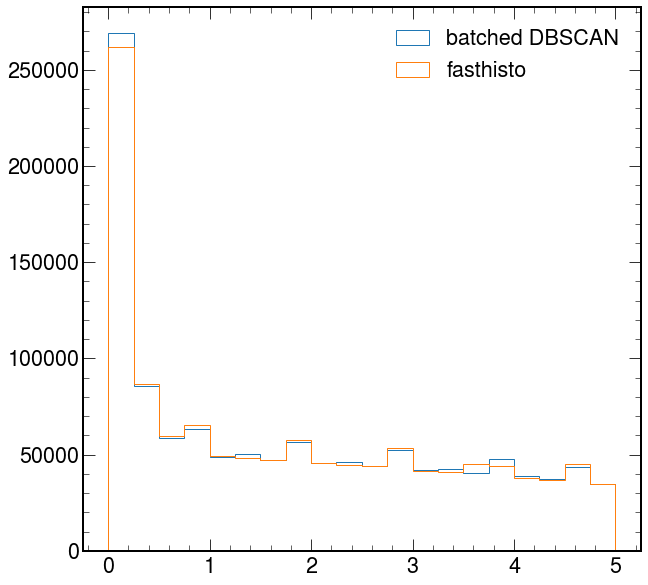

In [193]:
_, be, _ = plt.hist(
    pm.trk.distance_from_pv_bdb,
    bins=20,
    range=(0, 5),
    histtype="step",
    label="batched DBSCAN",
)
_ = plt.hist(pm.trk.distance_from_pv_fh, bins=be, histtype="step", label="fasthisto")
# _ = plt.hist(pm.trk.distance_from_pv_db, bins=be, histtype='step',label='dbscan')
plt.legend()

## Confusion matrix, because I'm confused

In [194]:
from sklearn.metrics import confusion_matrix

In [294]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [195]:
labels = ["TN", "FP", "FN", "TP"]
categories = ["Primary Vertex", "Not Primary Vertex"]

In [196]:
cf_fh = confusion_matrix(pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_fh_cor"].values, nor)
cf_db = confusion_matrix(pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_db_cor"].values)

In [290]:
cf_bdb = confusion_matrix(
    pm.trk["is_pv"].values, pm.trk["trk_pv_assoc_bdb_cor"].values, normalize="true"
)

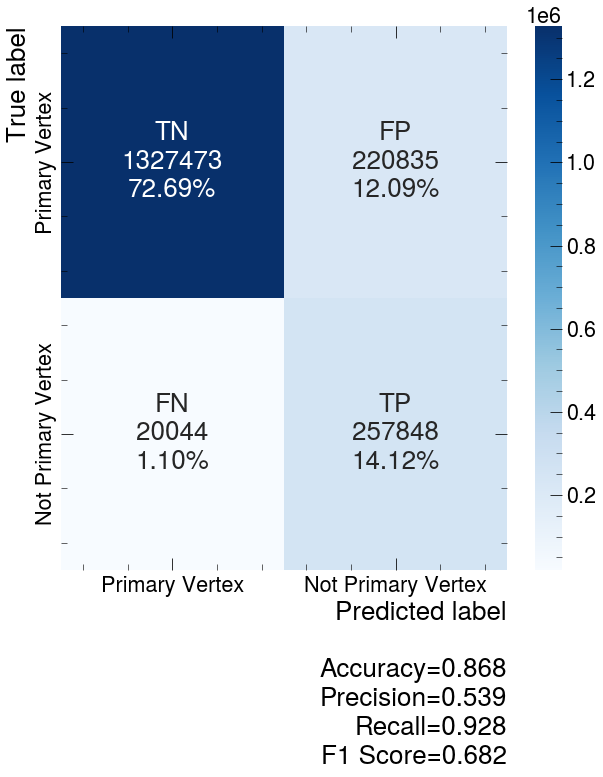

In [198]:
pm.make_confusion_matrix(cf_fh, group_names=labels, categories=categories)

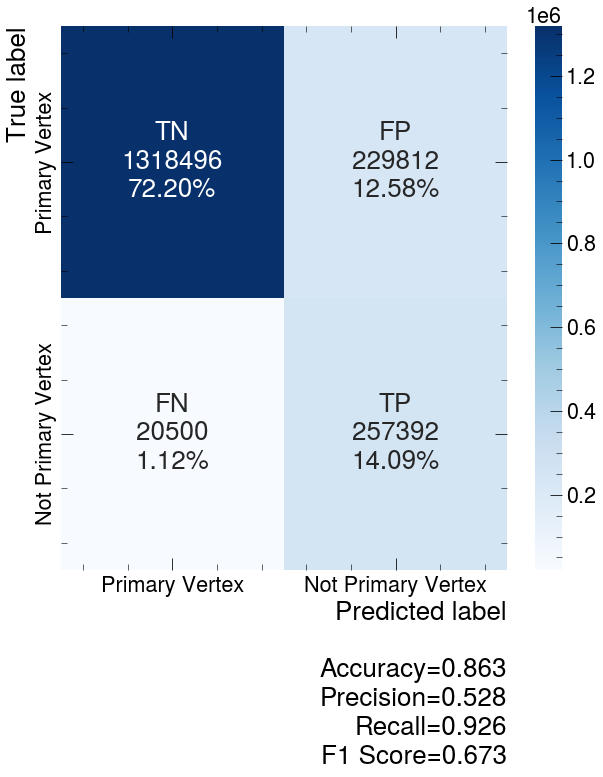

In [199]:
pm.make_confusion_matrix(cf_db, group_names=labels, categories=categories)

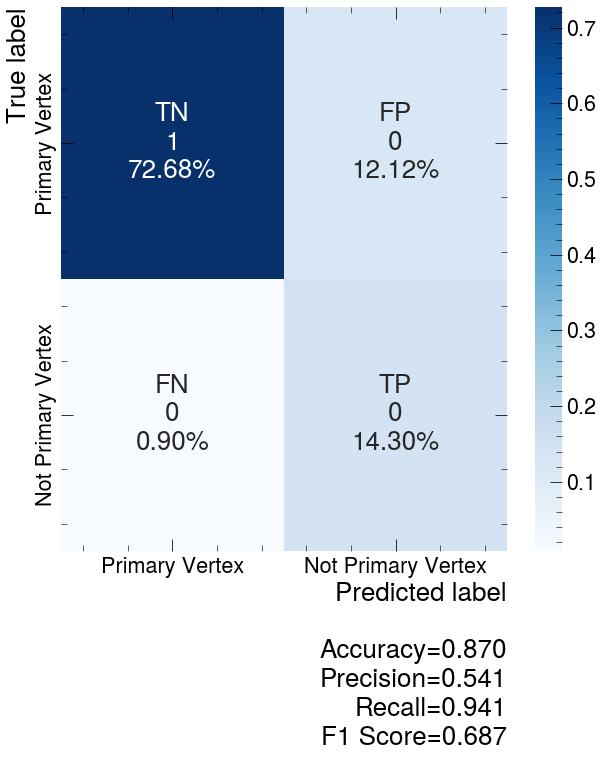

In [288]:
pm.make_confusion_matrix(cf_bdb, group_names=labels, categories=categories)

In [291]:
cf_bdb

array([[0.86, 0.14],
       [0.06, 0.94]])

Text(0.5, 1.0, 'DBSCAN')

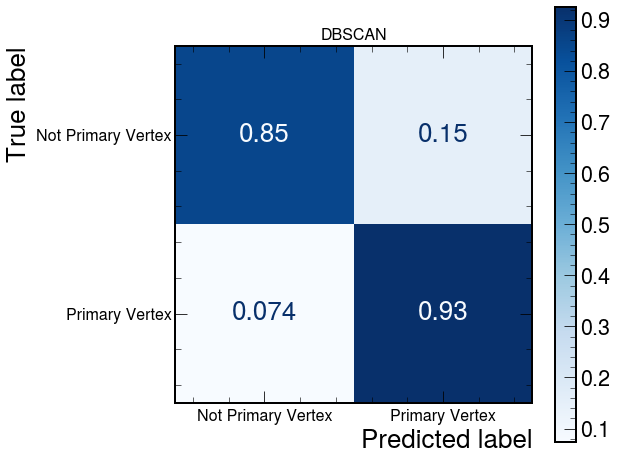

In [298]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay.from_predictions(
    pm.trk["is_pv"].values,
    pm.trk["trk_pv_assoc_db_cor"].values,
    display_labels=["Not Primary Vertex", "Primary Vertex"],
    cmap="Blues",
    normalize="true",
    ax=ax,
)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.title("DBSCAN", fontsize=16)

Text(0.5, 1.0, 'Batched DBSCAN + $p_T$ selection')

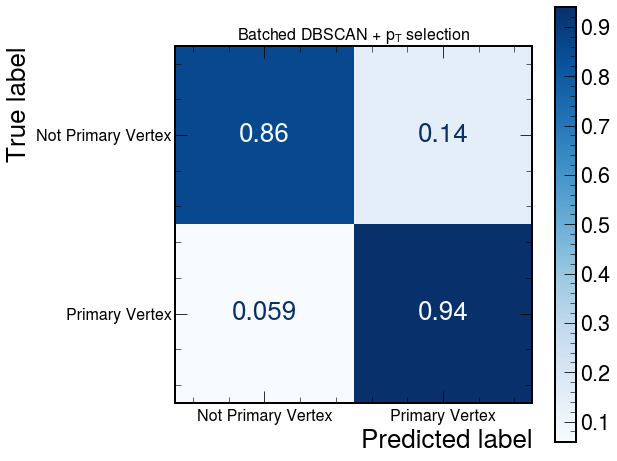

In [297]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay.from_predictions(
    pm.trk["is_pv"].values,
    pm.trk["trk_pv_assoc_bdb_cor"].values,
    display_labels=["Not Primary Vertex", "Primary Vertex"],
    cmap="Blues",
    normalize="true",
    ax=ax,
)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.title("Batched DBSCAN + $p_T$ selection", fontsize=16)